## **Import libraries**

In [374]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize']= (12, 8)
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
import plotly.express as px
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import  cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso , Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import joblib


## **Load Data**

In [376]:
# loading the csv file
df= pd.read_csv("medical_insurance.csv") 
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [378]:
#checking the shape of the dataframe
df.shape

(2772, 7)

In [379]:
#checking the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


## **Exploratory Data Analysis**

In [381]:
#descriptive statistics
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [382]:
#descriptive statistics of non numeric variables
df.describe(include = 'object')

,sex,smoker,region
count,2772,2772,2772
unique,2,2,4
top,male,no,southeast
freq,1406,2208,766


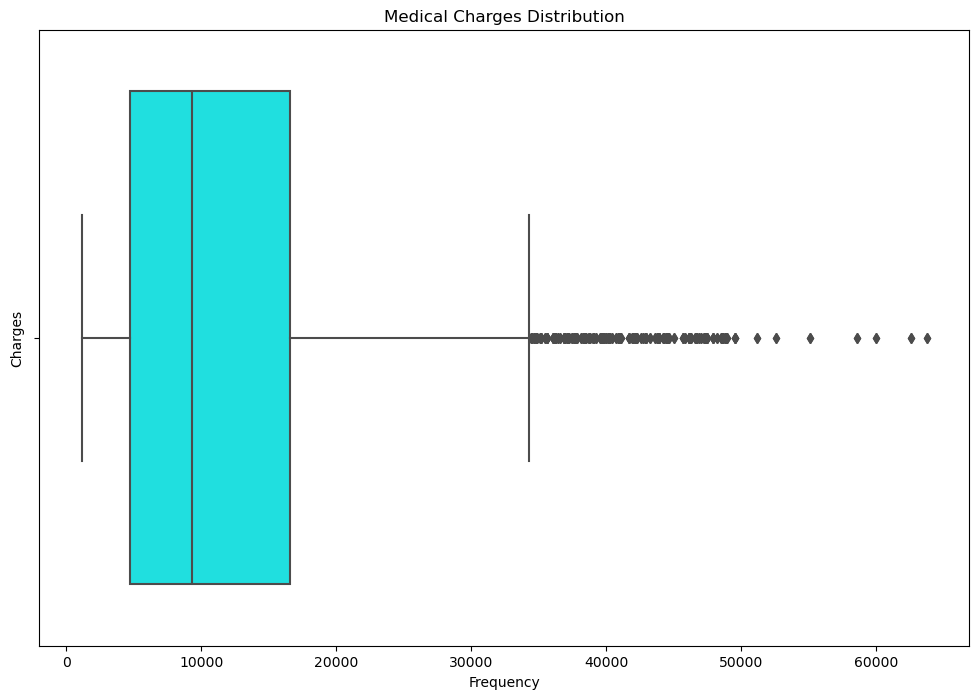

In [383]:
#checking outliers in the charges 
sns.boxplot(df, x = 'charges', color = 'cyan')
plt.xlabel("Frequency")
plt.ylabel('Charges')
plt.title("Medical Charges Distribution");

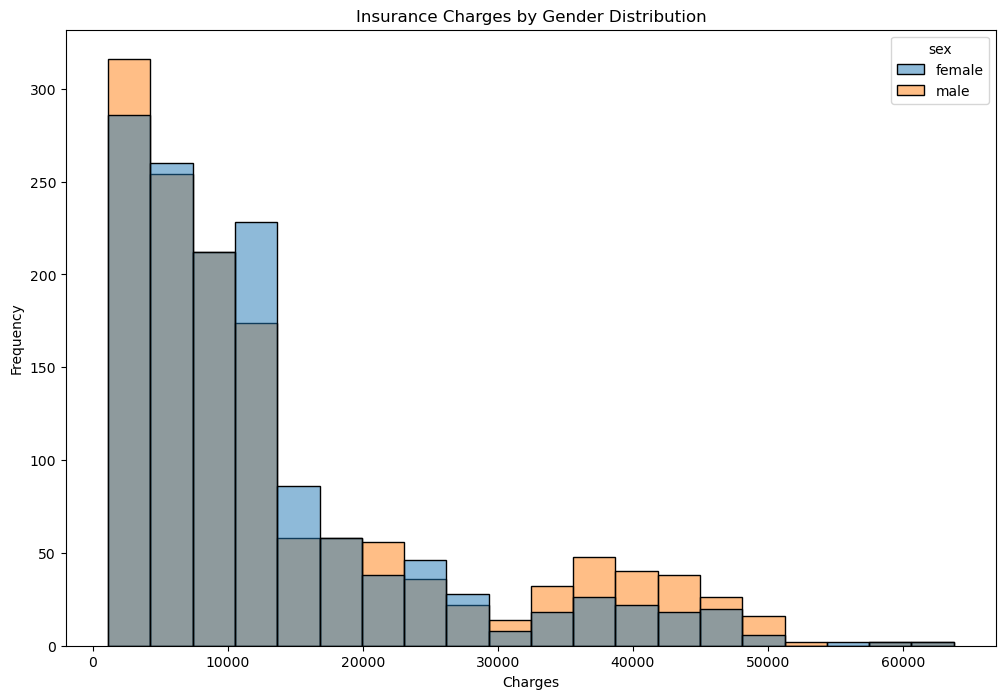

In [384]:
# distribution of charges by gender
sns.histplot(df,
             x ='charges',
             bins = 20,
             hue = 'sex')
plt.xlabel('Charges'),
plt.ylabel('Frequency')
plt.title('Insurance Charges by Gender Distribution');

    


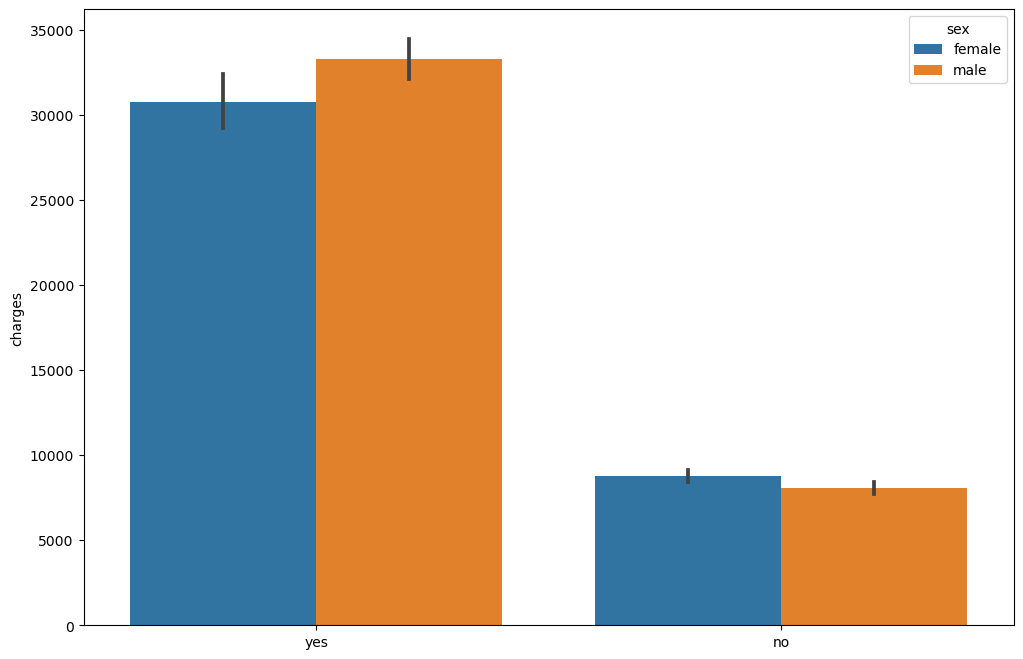

In [385]:
sns.barplot(df, x = "smoker", hue = 'sex',
           y = 'charges')
plt.xlabel("");

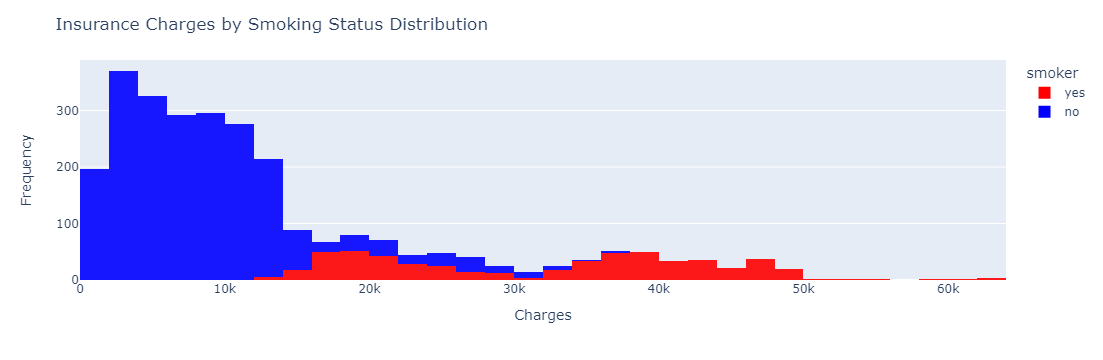

In [386]:
# distribution of charges by smoking status
fig = px.histogram(df, x ='charges',  color = 'smoker', opacity = 0.9, color_discrete_sequence=['red', 'blue'])
fig.update_layout(
    xaxis_title = 'Charges',
    yaxis_title = 'Frequency',
    title = 'Insurance Charges by Smoking Status Distribution'

    
)
fig.show()

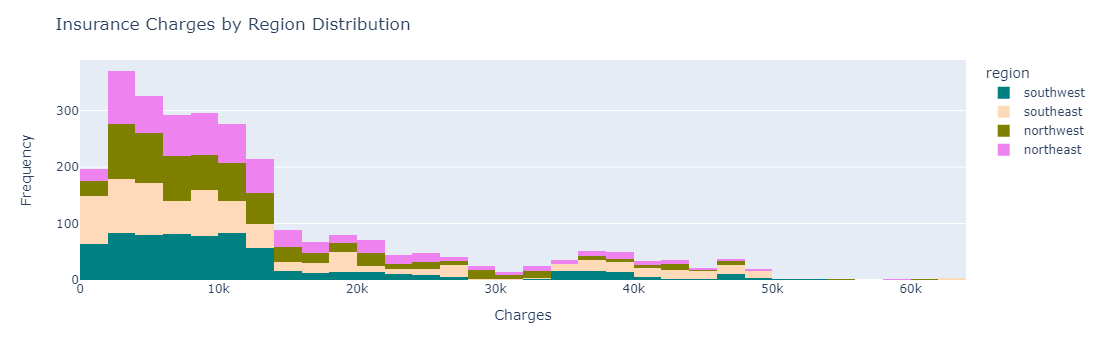

In [387]:
# distribution of charges by region
fig = px.histogram(df, x ='charges',
                   color = 'region',
                   color_discrete_sequence=['teal', 'peachpuff', 'olive', 'violet'])
fig.update_layout(
    xaxis_title = 'Charges',
    yaxis_title = 'Frequency',
    title = 'Insurance Charges by Region Distribution'

    
)
fig.show()

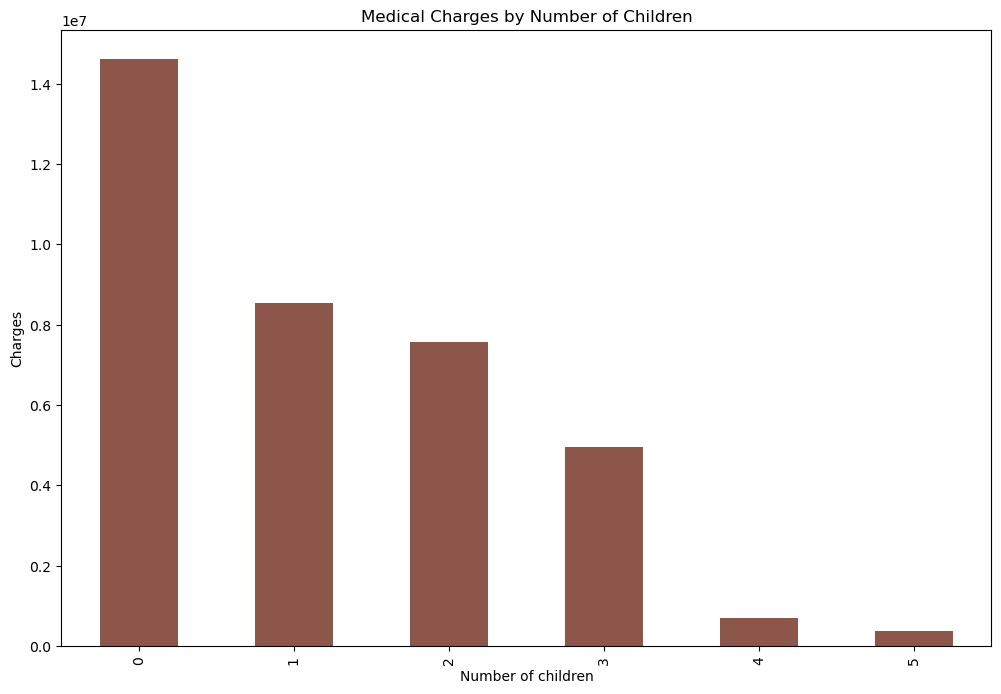

In [388]:
# charges by number of children
df.groupby('children')['charges'].sum().plot(kind = 'bar', color = 'C5')
plt.xlabel("Number of children")
plt.ylabel('Charges')
plt.title("Medical Charges by Number of Children")
plt.show()


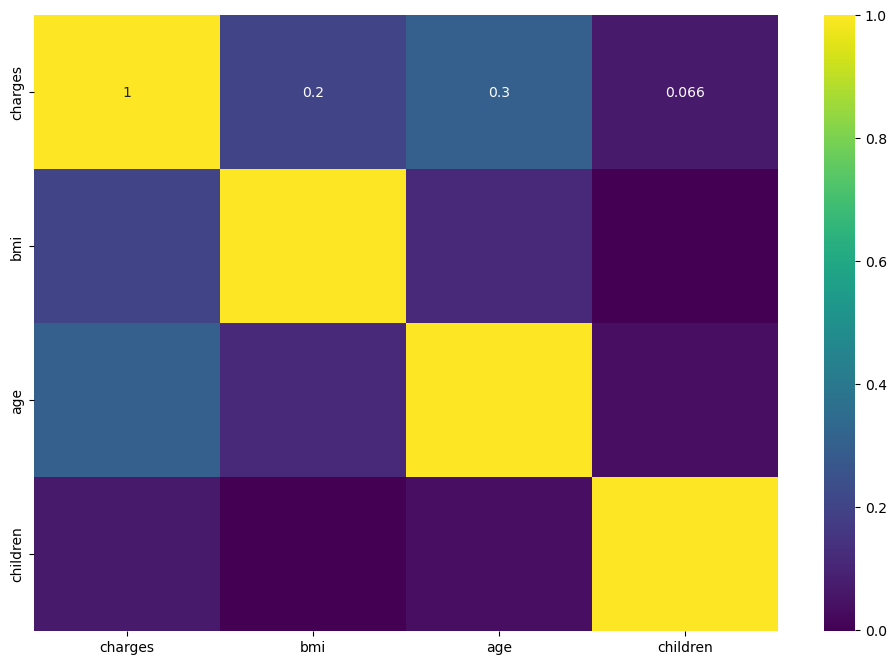

In [389]:
#numerical variables correlation
corr = df[['charges', 'bmi', 'age', 'children']].corr()
sns.heatmap(corr, annot = True, cmap = 'viridis');

## **Target and Features Selection**

In [391]:

target = 'charges'
features = df.drop(columns = target)
y = df[target]
X = features

### **Data Preprocessing**

In [393]:
# one hot encode  'sex' and 'smoker' and 'region' columns
label = X[['sex', 'smoker', 'region']]
#use One Hot Encoder
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform = 'pandas')
#fit the training data
encoded = ohe.fit_transform(label)


In [394]:
#create a Dataframe of the encoded data
encoded_df = pd.DataFrame(encoded )

encoded_df.head()

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [395]:
#concatenate the X features and encoded_df DataFrames and drop the uncoded columns 
X_df = pd.concat([X, encoded_df], axis = 1).drop(columns =['sex', 'smoker', 'region'])
X_df.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### **Splitting Data**

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.3, random_state = 42)
print("X_train is", X_train.shape)
print("X_test is", X_test.shape)
print("y_train is", y_train.shape)
print("y_test is", X_test.shape)

X_train is (1940, 11)
X_test is (832, 11)
y_train is (1940,)
y_test is (832, 11)


### **Training The LinearRegression Model**

In [399]:
# Using the LinearRegression Model
l_reg = LinearRegression()
# fit the model
l_reg.fit(X_train, y_train)


LinearRegression()

In [400]:
#checking the score on training data
l_reg_score_train = l_reg.score(X_train, y_train)
l_reg_score_train

0.7536565270426124

In [401]:
#checking the score on test data
l_reg_score_test = l_reg.score(X_test, y_test)
l_reg_score_test

0.744330812569293

### Predictions

In [403]:
#predicting on training data
l_reg_train_pred = l_reg.predict(X_train)
l_reg_train_pred[:5]

array([32213.92589157, 13924.00980811,  3525.62330466, 13926.12399653,
        9509.83250827])

In [404]:
#predicting on test data
l_reg_test_pred = l_reg.predict(X_test)
l_reg_test_pred[:5]

array([10204.3701317 , 36719.40159231,  9128.45120517,  5782.46663686,
        6545.75971835])

### **Training The Ridge Model**

In [406]:
#instantiate the Ridge model
r_model = Ridge()
#fit the model
r_model.fit(X_train, y_train)

Ridge()

In [407]:
#checking the score on training data
r_score_train = r_model.score(X_train, y_train)
r_score_train

0.7536549151229868

In [408]:
#checking the score on test data
r_score_test = r_model.score(X_test, y_test)
r_score_test

0.7442643285508963

### Predictions 

In [410]:
#predicting on training data
r_train_pred = r_model.predict(X_train)
r_train_pred[:5]

array([32184.01280092, 13929.12216525,  3531.8546719 , 13933.16290614,
        9521.12672157])

In [411]:
#predicting on test data
r_test_pred = r_model.predict(X_test)
r_test_pred[:5]

array([10209.86613701, 36688.61935439,  9134.64470584,  5790.06101355,
        6551.21379419])

### **Training The  Lasso Model**

In [413]:
#instantiate the Lasso Model
l_model = Lasso()
#fit model
l_model.fit(X_train, y_train)

Lasso()

In [414]:
#checking the score on training data
l_score_train = l_model.score(X_train, y_train)
l_score_train

0.7536563228193358

In [415]:
#checking the score on test data
l_score_test = l_model.score(X_test, y_test)
l_score_test

0.7443062880297752

### Predictions

In [417]:
#predicting on training data
l_train_pred = l_model.predict(X_train)
l_train_pred[:5]

array([32204.17552587, 13917.41738263,  3522.16984375, 13924.69154838,
        9517.25644928])

In [418]:
#predicting on test data
l_test_pred_l = l_model.predict(X_test)
l_test_pred_l[:5]

array([10199.97563929, 36713.55517245,  9133.8174206 ,  5788.5504275 ,
        6537.84859703])

### **Training The  Random Forest  Model**

In [420]:
#instantiate the Random Forest Model
rf_model = RandomForestRegressor(n_estimators = 200,max_depth = None , random_state = 42)
#fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [421]:
#checking the score on training data
rf_score_train = rf_model.score(X_train, y_train)
rf_score_train

0.9906372374798678

In [422]:
#checking the score on test data
rf_score_test = rf_model.score(X_test, y_test)
rf_score_test

0.9332093550136636

### Predictions

In [424]:
#predicting on training data
rf_train_pred = rf_model.predict(X_train)
rf_train_pred[:5]

array([39292.1113901 , 12276.81527325,  3745.6814894 , 11888.95518425,
        6300.8260945 ])

In [425]:
#predicting on test data
rf_test_pred = rf_model.predict(X_test)
rf_test_pred[:5]

array([ 9152.8719169 , 28281.12570385, 12076.99243885,  1938.54863375,
        4719.3967763 ])

## **Model Evaluation**

**Extracting the mean absolute errors**

In [428]:
# Defining the models
models = [l_reg, r_model, l_model, rf_model]

# Defining the evaluation function
def evaluate(models, X_test, y_test):
    mae_results = []
    for model in models:
        # Predicting on X_test
        y_pred = model.predict(X_test)
        # Calculating MAE
        mae = mean_absolute_error(y_test, y_pred)
        # Store the model name and MAE in a dictionary
        mae_results.append({'model': model.__class__.__name__, 'mae': mae})
    return mae_results

# the evaluation function
mae_results = evaluate(models, X_test, y_test)
print(mae_results)

[{'model': 'LinearRegression', 'mae': 4224.767553044481}, {'model': 'Ridge', 'mae': 4227.755813550967}, {'model': 'Lasso', 'mae': 4225.241431003301}, {'model': 'RandomForestRegressor', 'mae': 1478.4044293105787}]


**Extracting the r2 scores**

In [430]:
# Define the models
models = [l_reg, r_model, l_model, rf_model]

# Define the evaluation function
def evaluate(models, X_test, y_test):
    r2_results = []
    for model in models:
        # Predict on X_test
        y_pred = model.predict(X_test)
        # Calculate MAE
        r2 = r2_score(y_test, y_pred)
        # Store the model name and MAE in a dictionary
        r2_results.append({'model': model.__class__.__name__, 'r2score': r2})
    return r2_results

# Call the evaluation function
r2_results = evaluate(models, X_test, y_test)
print(r2_results)

[{'model': 'LinearRegression', 'r2score': 0.744330812569293}, {'model': 'Ridge', 'r2score': 0.7442643285508963}, {'model': 'Lasso', 'r2score': 0.7443062880297752}, {'model': 'RandomForestRegressor', 'r2score': 0.9332093550136636}]


In [431]:
r2_df = pd.DataFrame(r2_results)['r2score']
r2_df

0    0.744331
1    0.744264
2    0.744306
3    0.933209
Name: r2score, dtype: float64

### **Gridsearch**

In [433]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Random Forest Model
rf = RandomForestRegressor()

# Hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)


{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


**Extracting the cross validation score**

In [435]:
# Define the models
models = [l_reg, r_model, l_model, rf_model]

# Define the evaluation function
def evaluate(models, X, y):
    results = []
    for model in models:
        # Calculate MAE
        mae = mean_absolute_error(y_test, model.predict(X_test))
        # Calculate cross-validation score
        cv_score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        cv_score = -cv_score.mean()  # Converting to positive MAE
        # Store the model name, MAE, and CV score in a dictionary
        results.append({
            'model': model.__class__.__name__,
            'mae': mae,
            'cv_score': cv_score
        })
    return results

# Call the evaluation function
cv_results = evaluate(models, X_test, y_test)
print(cv_results)

[{'model': 'LinearRegression', 'mae': 4224.767553044481, 'cv_score': 4354.717434144568}, {'model': 'Ridge', 'mae': 4227.755813550967, 'cv_score': 4363.437310976233}, {'model': 'Lasso', 'mae': 4225.241431003301, 'cv_score': 4354.7333321124315}, {'model': 'RandomForestRegressor', 'mae': 1478.4044293105787, 'cv_score': 2436.1021478665134}]


In [436]:
cv_df = pd.DataFrame(cv_results)
cv_df

,model,mae,cv_score
0,LinearRegression,4224.767553,4354.717434
1,Ridge,4227.755814,4363.437311
2,Lasso,4225.241431,4354.733332
3,RandomForestRegressor,1478.404429,2436.102148


In [437]:
#concatenate the Dataframes
model_perf = pd.concat([cv_df, r2_df], axis = 1).set_index('model').sort_values(ascending = False, by = 'cv_score')
model_perf

,mae,cv_score,r2score
model,,,
Ridge,4227.755814,4363.437311,0.744264
Lasso,4225.241431,4354.733332,0.744306
LinearRegression,4224.767553,4354.717434,0.744331
RandomForestRegressor,1478.404429,2436.102148,0.933209


## **Feature Importances**

In [439]:
# extract feature importances
feat_imp = rf_model.feature_importances_


In [440]:
# create a data frame of feature importances
feature_importances = pd.DataFrame({'feature': X_df.columns , 'importance' : feat_imp}).sort_values(by = 'importance', ascending = False)
feature_importances

,feature,importance
5,smoker_no,0.496625
1,bmi,0.203269
0,age,0.130140
6,smoker_yes,0.127625
2,children,0.017984
7,region_northeast,0.005381
8,region_northwest,0.004911
9,region_southeast,0.003772
3,sex_female,0.003682
4,sex_male,0.003591


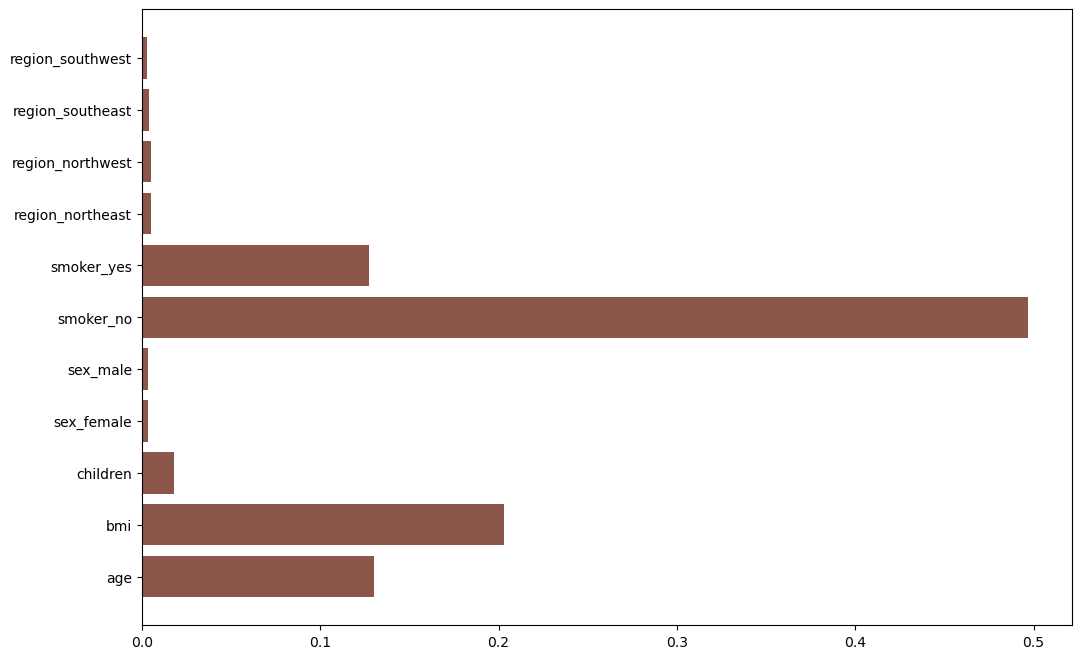

In [441]:
#plot a bar chart for the feature importances
plt.barh(X_df.columns , feat_imp, color = 'C5');

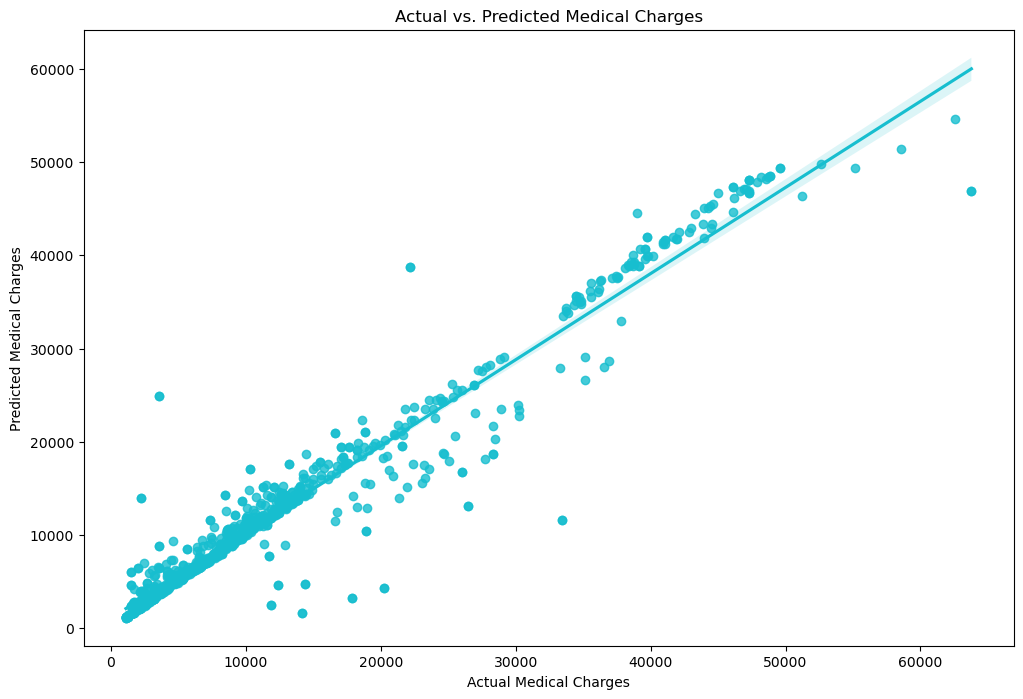

In [442]:
sns.regplot(x = y_test, y = rf_test_pred,  color = 'C9')
plt.xlabel('Actual Medical Charges')
plt.ylabel('Predicted Medical Charges')
plt.title('Actual vs. Predicted Medical Charges')

plt.show()

In [443]:
# Saving the Random Forest model to a file
joblib.dump(rf_model, 'med_charges_random_forest_model.pkl')


['med_charges_random_forest_model.pkl']